In [1]:
#Import python libraries to be used for the project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
df1 = pd.read_csv('C:/Users/hkkam/Desktop/MLV_2/AirData/June.csv')
df2 = pd.read_csv('C:/Users/hkkam/Desktop/MLV_2/AirData/July.csv')
df3 = pd.read_csv('C:/Users/hkkam/Desktop/MLV_2/AirData/August.csv')
frames = [df1,df2, df3]
df = pd.concat(frames)
df=df.drop(['YEAR','Unnamed: 22'], axis=1)

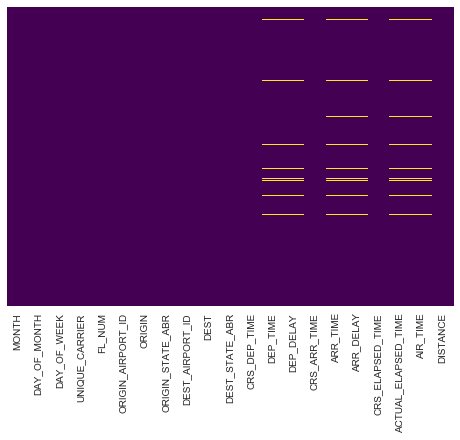

In [3]:
#Visualize missing data
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

In [4]:
#Drop Rows with some columns empty
df.dropna(subset = ['UNIQUE_CARRIER','ORIGIN','DEST','CRS_DEP_TIME','CRS_ARR_TIME',
                    'ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE'],inplace=True)

In [5]:
#Get the Departure and Arrival Hours#Get the 
#For DEP_HOUR, take the CRS_DEP_TIME
df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df['CRS_DEP_HOUR'] = df['CRS_DEP_HOUR'].apply(lambda x:0 if x==24 else x)

##### For ARR_HOUR, take the actual arrival time
df['CRS_ARR_HOUR'] = df['CRS_ARR_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df['CRS_ARR_HOUR'] = df['CRS_ARR_HOUR'].apply(lambda x:0 if x==24 else x)

In [6]:
df.to_csv('Full_airline_data.csv',index=False)

In [7]:
#Create a new dataframe list of all airports
airports_df = pd.DataFrame(pd.concat([df['ORIGIN'],df['DEST']]),columns={'IATA'})
#airports_df.head()

#Select the Top 20 Airports from the airport list 
top_20_ports = pd.DataFrame(airports_df['IATA'].value_counts().head(20)).reset_index()
top_20_ports.rename(index=str, columns={"index":"IATA","IATA":"Count"},inplace=True)

In [8]:
#Save the top 50 airports in a CSV file
top_20_ports.to_csv('top20ports.csv',index=False)

# Restrict Airlines To Top 20 Airports

In [9]:
df = pd.read_csv('Full_airline_data.csv') #Loading Saved Airlines Data

In [10]:
#Make subset of data containing only flights from top 20 airports
top_20_ports = pd.read_csv('top20ports.csv')['IATA'].tolist()
df_sub = df[df['ORIGIN'].isin(top_20_ports)]
df_sub = df_sub[df_sub['DEST'].isin(top_20_ports)]

In [14]:
data_retained = len(df_sub.index)/len(df.index)
print('Data Retained of original airlines data: '+str(round(data_retained*100,2))+' %'+' = '+str(len(df_sub)))

Data Retained of original airlines data: 23.36 % = 350844


# Load Weather Data, Preprocess and Merge With Airlines Data

In [15]:
#Read weather data file
df_weather = pd.read_csv('C:/Users/hkkam/Desktop/MLV_2/Weather_Info/NOA.csv',low_memory=False)

#Select the weather parameters which affect flight status: Visibility, Temperature, Wind Speed, Precipitation
df_weather = df_weather[['STATION_NAME','DATE','HOURLYVISIBILITY','HOURLYDRYBULBTEMPC','HOURLYWindSpeed','HOURLYPrecip']].copy()

In [16]:
df_weather['STATION_NAME'].value_counts()

DENVER INTERNATIONAL AIRPORT CO US                  3533
DETROIT METROPOLITAN AIRPORT MI US                  3423
CHARLOTTE DOUGLAS AIRPORT NC US                     3399
BOSTON MA US                                        3393
LA GUARDIA AIRPORT NY US                            3328
JFK INTERNATIONAL AIRPORT NY US                     3301
DAL FTW WSCMO AIRPORT TX US                         3284
MINNEAPOLIS ST PAUL INTERNATIONAL AIRPORT MN US     3270
CHICAGO OHARE INTERNATIONAL AIRPORT IL US           3174
SALT LAKE CITY INTERNATIONAL AIRPORT UT US          3132
ATLANTA HARTSFIELD INTERNATIONAL AIRPORT GA US      3110
LOS ANGELES INTERNATIONAL AIRPORT CA US             3055
ORLANDO INTERNATIONAL AIRPORT FL US                 3052
HOUSTON INTERCONTINENTAL AIRPORT TX US              3048
BALTIMORE WASHINGTON INTERNATIONAL AIRPORT MD US    3033
SEATTLE TACOMA INTERNATIONAL AIRPORT WA US          3019
NEWARK LIBERTY INTERNATIONAL AIRPORT NJ US          2960
SAN FRANCISCO INTERNATIONAL AIR

In [17]:
#Extract the Year, Month, Date and Hour from df_weather
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])
df_weather['YEAR']= df_weather['DATE'].apply(lambda time: time.year)
df_weather['MONTH']= df_weather['DATE'].apply(lambda time: time.month)
df_weather['DAY_OF_MONTH']= df_weather['DATE'].apply(lambda time: time.day)
df_weather['HOUR']= df_weather['DATE'].apply(lambda time: time.hour)

#Delete duplicate rows with data from the same station and same date/hour
df_weather.drop_duplicates(['STATION_NAME','YEAR','MONTH','DAY_OF_MONTH','HOUR'],inplace=True) #Remove duplicate
df_weather.drop('DATE',axis = 1,inplace=True) #Drop date from the df_weather dataframe
df_weather.drop('YEAR',axis = 1,inplace=True) #Drop year from the df_weather dataframe

In [18]:
#Function to convert string in weather data to floats
def tryconvert(x):
        try:
            if str(x)[-1].isalpha():
                return(float(str(x)[:-1]))
            else:
                return(float(str(x)))
        except:
            return(np.nan)

In [19]:
df_weather['HOURLYVISIBILITY'] = df_weather['HOURLYVISIBILITY'].apply(lambda x: tryconvert(x))
df_weather['HOURLYDRYBULBTEMPC'] = df_weather['HOURLYDRYBULBTEMPC'].apply(lambda x: tryconvert(x))
df_weather['HOURLYWindSpeed'] = df_weather['HOURLYWindSpeed'].apply(lambda x: tryconvert(x))
df_weather['HOURLYPrecip'] = df_weather['HOURLYPrecip'].apply(lambda x: tryconvert(x))

In [20]:
#Replace NaNs with 0 in Hourly Precip
df_weather['HOURLYPrecip'].fillna(value=0,inplace=True)

#Replace NaNs with average value for Hourly Visibility
df_weather['HOURLYVISIBILITY'].fillna(df_weather['HOURLYVISIBILITY'].mean(),inplace=True)

In [21]:
#Replacing the weather station names with the IATA CODES for the airports
df_weather['STATION_NAME'].replace('DENVER INTERNATIONAL AIRPORT CO US','DEN',inplace=True)
df_weather['STATION_NAME'].replace('DETROIT METROPOLITAN AIRPORT MI US','DTW',inplace=True)
df_weather['STATION_NAME'].replace('CHARLOTTE DOUGLAS AIRPORT NC US','CLT',inplace=True)
df_weather['STATION_NAME'].replace('BOSTON MA US','BOS',inplace=True)
df_weather['STATION_NAME'].replace('LA GUARDIA AIRPORT NY US','LGA',inplace=True)
df_weather['STATION_NAME'].replace('ATLANTA HARTSFIELD INTERNATIONAL AIRPORT GA US','ATL',inplace=True)
df_weather['STATION_NAME'].replace('CHICAGO OHARE INTERNATIONAL AIRPORT IL US','ORD',inplace=True)
df_weather['STATION_NAME'].replace('DAL FTW WSCMO AIRPORT TX US','DFW',inplace=True)
df_weather['STATION_NAME'].replace('LOS ANGELES INTERNATIONAL AIRPORT CA US','LAX',inplace=True)
df_weather['STATION_NAME'].replace('PHOENIX SKY HARBOR INTERNATIONAL AIRPORT AZ US','PHX',inplace=True)
df_weather['STATION_NAME'].replace('HOUSTON INTERCONTINENTAL AIRPORT TX US','IAH',inplace=True)
df_weather['STATION_NAME'].replace('MINNEAPOLIS ST PAUL INTERNATIONAL AIRPORT MN US','MSP',inplace=True)
df_weather['STATION_NAME'].replace('SEATTLE TACOMA INTERNATIONAL AIRPORT WA US','SEA',inplace=True)
df_weather['STATION_NAME'].replace('ORLANDO INTERNATIONAL AIRPORT FL US','MCO',inplace=True)
df_weather['STATION_NAME'].replace('NEWARK LIBERTY INTERNATIONAL AIRPORT NJ US','EWR',inplace=True)
df_weather['STATION_NAME'].replace('SALT LAKE CITY INTERNATIONAL AIRPORT UT US','SLC',inplace=True)
df_weather['STATION_NAME'].replace('JFK INTERNATIONAL AIRPORT NY US','JFK',inplace=True)
df_weather['STATION_NAME'].replace('BALTIMORE WASHINGTON INTERNATIONAL AIRPORT MD US','BWI',inplace=True)
df_weather['STATION_NAME'].replace('SAN FRANCISCO INTERNATIONAL AIRPORT CA US','SFO',inplace=True)
df_weather['STATION_NAME'].replace('LAS VEGAS MCCARRAN INTERNATIONAL AIRPORT NV US','LAS',inplace=True)
df_weather['STATION_NAME'].replace('PHOENIX AIRPORT AZ US','PHX',inplace=True)

# Getting Average Weather Values For Each Station

In [22]:
df_avg_DEP = df_weather.groupby('STATION_NAME').mean()
df_avg_DEP.drop(['MONTH','DAY_OF_MONTH','HOUR'],axis = 1,inplace=True)
df_avg_DEP.reset_index(drop=False,inplace=True)
df_avg_DEP.rename(index=str, columns={"STATION_NAME": "ORIGIN"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HOURLYVISIBILITY": "DEP_AVG_HOURLYVISIBILITY"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HOURLYDRYBULBTEMPC": "DEP_AVG_HOURLYDRYBULBTEMPC"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HOURLYWindSpeed": "DEP_AVG_HOURLYWindSpeed"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HOURLYPrecip": "DEP_AVG_HOURLYPrecip"},inplace=True)

df_avg_ARR = df_weather.groupby('STATION_NAME').mean()
df_avg_ARR.drop(['MONTH','DAY_OF_MONTH','HOUR'],axis = 1,inplace=True)
df_avg_ARR.reset_index(drop=False,inplace=True)
df_avg_ARR.rename(index=str, columns={"STATION_NAME": "DEST"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HOURLYVISIBILITY": "ARR_AVG_HOURLYVISIBILITY"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HOURLYDRYBULBTEMPC": "ARR_AVG_HOURLYDRYBULBTEMPC"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HOURLYWindSpeed": "ARR_AVG_HOURLYWindSpeed"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HOURLYPrecip": "ARR_AVG_HOURLYPrecip"},inplace=True)

In [23]:
#Create two copies of the Weather Dataframe, so that we can two Joins, one for Origin, and one for Destination
df_weather_origin = df_weather.copy()
df_weather_dest = df_weather.copy()


#Rename the Columns, add DEP_ to each column name and STATION_NAME to ORIGIN
df_weather_origin.rename(index=str, columns={"STATION_NAME": "ORIGIN"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOURLYVISIBILITY": "DEP_HOURLYVISIBILITY"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOURLYDRYBULBTEMPC": "DEP_HOURLYDRYBULBTEMPC"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOURLYWindSpeed": "DEP_HOURLYWindSpeed"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOURLYPrecip": "DEP_HOURLYPrecip"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOUR": "CRS_DEP_HOUR"},inplace=True)

#Rename the Columns, add ARR_ to each column name and STATION_NAME to DEST
df_weather_dest.rename(index=str, columns={"STATION_NAME": "DEST"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOURLYVISIBILITY": "ARR_HOURLYVISIBILITY"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOURLYDRYBULBTEMPC": "ARR_HOURLYDRYBULBTEMPC"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOURLYWindSpeed": "ARR_HOURLYWindSpeed"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOURLYPrecip": "ARR_HOURLYPrecip"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOUR": "CRS_ARR_HOUR"},inplace=True)

# Merge Weather Data and Airlines Data

In [24]:
#Merge the Actual Weather during Take-off and Landing for each flight 
df_sub = pd.merge(df_sub, df_weather_origin, on=['ORIGIN','MONTH','DAY_OF_MONTH','CRS_DEP_HOUR'], how='left')
df_sub = pd.merge(df_sub, df_weather_dest, on=['DEST','MONTH','DAY_OF_MONTH','CRS_ARR_HOUR'], how='left')

In [25]:
#Merge the Average weather for Origin and Destination Airports for each flight:
df_sub = pd.merge(df_sub,df_avg_DEP,how='left',on='ORIGIN')
df_sub = pd.merge(df_sub,df_avg_ARR,how='left',on='DEST')

In [26]:
#Criteria for classifying a flights as late or not
#class as late if arrival time exceed 3 mins after CRS arrival time
df_sub['ARR_DELAY']=df_sub['ARR_DELAY'].apply(lambda x:1 if x>=1 else 0)

In [ ]:
list(df_sub)

In [61]:
testdata = df_sub.copy()

In [62]:
testdata=testdata.drop(['FL_NUM','ORIGIN_AIRPORT_ID','ORIGIN_STATE_ABR',
 'DEST_AIRPORT_ID','DEST_STATE_ABR','DEP_TIME',
 'DEP_DELAY','ARR_TIME', 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME','DEP_HOURLYVISIBILITY',
 'DEP_HOURLYDRYBULBTEMPC',
 'DEP_HOURLYWindSpeed',
 'DEP_HOURLYPrecip','CRS_ARR_TIME',
 'ARR_HOURLYVISIBILITY','CRS_DEP_TIME',
 'ARR_HOURLYDRYBULBTEMPC',
 'ARR_HOURLYWindSpeed',
 'ARR_HOURLYPrecip',], axis=1)

In [63]:
testdata.shape

(350844, 19)

In [126]:
testdata['ARR_DELAY'].value_counts()

0    194697
1    156147
Name: ARR_DELAY, dtype: int64

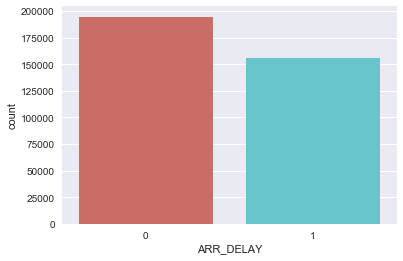

In [151]:
sns.countplot(x='ARR_DELAY',data=testdata, palette='hls')
plt.show()
plt.savefig('count_plot')

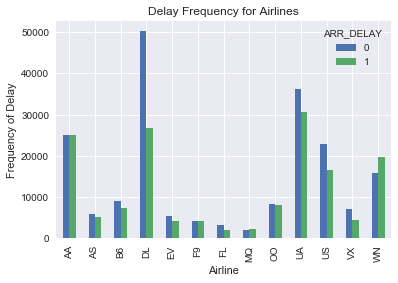

In [129]:
%matplotlib inline
pd.crosstab(testdata.UNIQUE_CARRIER,testdata.ARR_DELAY).plot(kind='bar')
plt.title('Delay Frequency for Airlines')
plt.xlabel('Airline')
plt.ylabel('Frequency of Delay')
plt.savefig('Airline_Delays')

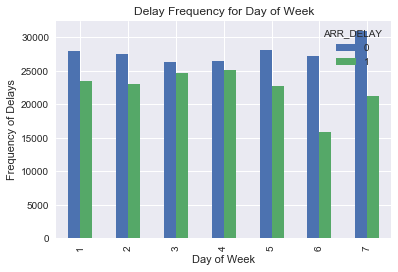

In [131]:
pd.crosstab(testdata.DAY_OF_WEEK,testdata.ARR_DELAY).plot(kind='bar')
plt.title('Delay Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Delays')
plt.savefig('delay_dayofweek_bar')

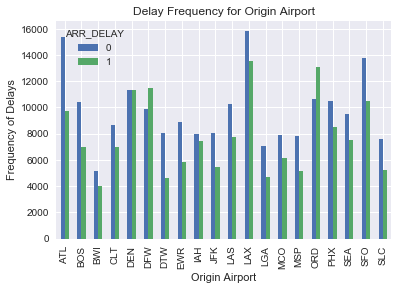

In [132]:
pd.crosstab(testdata.ORIGIN,testdata.ARR_DELAY).plot(kind='bar')
plt.title('Delay Frequency for Origin Airport')
plt.xlabel('Origin Airport')
plt.ylabel('Frequency of Delays')
plt.savefig('delay_originairport_bar')

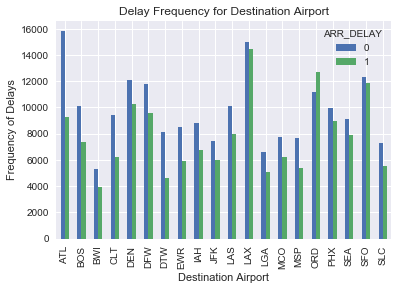

In [133]:
pd.crosstab(testdata.DEST,testdata.ARR_DELAY).plot(kind='bar')
plt.title('Delay Frequency for Destination Airport')
plt.xlabel('Destination Airport')
plt.ylabel('Frequency of Delays')
plt.savefig('delay_destairport_bar')

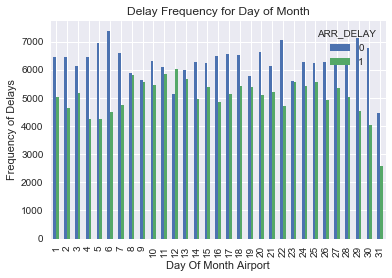

In [134]:
pd.crosstab(testdata.DAY_OF_MONTH,testdata.ARR_DELAY).plot(kind='bar')
plt.title('Delay Frequency for Day of Month')
plt.xlabel('Day Of Month Airport')
plt.ylabel('Frequency of Delays')
plt.savefig('delay_domairport_bar')

In [55]:
testdata.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_HOUR,...,ARR_HOURLYDRYBULBTEMPC,ARR_HOURLYPrecip,DEP_AVG_HOURLYVISIBILITY,DEP_AVG_HOURLYDRYBULBTEMPC,DEP_AVG_HOURLYWindSpeed,DEP_AVG_HOURLYPrecip,ARR_AVG_HOURLYVISIBILITY,ARR_AVG_HOURLYDRYBULBTEMPC,ARR_AVG_HOURLYWindSpeed,ARR_AVG_HOURLYPrecip
0,6,15,7,US,EWR,CLT,0,121.0,529.0,15,...,30.0,0.0,9.654816,23.735161,8.003172,0.001825,9.670888,24.872147,5.183877,0.001119
1,6,15,7,US,BOS,CLT,0,136.0,728.0,11,...,29.4,0.0,9.564469,21.541214,9.623924,0.001205,9.670888,24.872147,5.183877,0.001119
2,6,15,7,US,ATL,CLT,0,84.0,226.0,15,...,31.1,0.0,9.629588,25.375725,6.319746,0.001866,9.670888,24.872147,5.183877,0.001119
3,6,15,7,US,CLT,IAH,0,155.0,912.0,18,...,28.3,0.0,9.670888,24.872147,5.183877,0.001119,9.768494,28.047667,6.265972,0.001091
4,6,15,7,US,CLT,DFW,1,154.0,936.0,9,...,32.8,0.0,9.670888,24.872147,5.183877,0.001119,9.737453,28.761549,10.855978,0.000938


In [64]:
X = testdata.iloc[:, [0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18]].values

In [65]:
Y = testdata.iloc[:,6].values

In [66]:
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [67]:
#ENCODING ALL CATEGORICAL VARIABLES
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
labelencoder_x = LabelEncoder()
X[:, 0] = labelencoder_x.fit_transform(X[:,0])
X[:, 2] = labelencoder_x.fit_transform(X[:,2])
X[:, 3] = labelencoder_x.fit_transform(X[:,3])
X[:, 4] = labelencoder_x.fit_transform(X[:,4])
X[:, 5] = labelencoder_x.fit_transform(X[:,5])
onehotencoder = OneHotEncoder(categorical_features = [0,2,3,4,5])
X = onehotencoder.fit_transform(X).toarray()
            

In [69]:
#SPLIT THE DATASET INTO TRAINING AND TEST SET WITH THE TEST SIZE AS 20% OF THE ORIGINAL DATA
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.2, random_state=0)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=0)

In [70]:
#Feature Scaling the training dataset ::: Standardization
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Train With The LassoCV

In [71]:
from sklearn import linear_model 
l_classifier = linear_model.LassoCV() #Use the default parameters

In [72]:
tic = time.time()
l_classifier.fit(x_train, y_train)
toc = time.time()
print("Finished Training Data in " + str(toc-tic) + " seconds")

Finished Training Data in 25.633293390274048 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [73]:
l_pred = l_classifier.predict(x_test)

In [74]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, (l_pred>0.5).astype(int))

0.62081545981843833

In [75]:
l_classifier.alpha_

8.1021750203295721e-05

In [78]:
l_classifier.coef_ !=0

array([ True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True,  True], dtype=bool)

In [82]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, (l_pred>0.5).astype(int)))

             precision    recall  f1-score   support

          0       0.63      0.76      0.69     39092
          1       0.60      0.45      0.51     31077

avg / total       0.62      0.62      0.61     70169



# LassoCV 2

In [140]:
l_alpha = np.arange(0.0001, 0.001, 0.00025)
l_alpha

array([ 0.0001 ,  0.00035,  0.0006 ,  0.00085])

In [141]:
l_classifier2 = linear_model.LassoCV(alphas = l_alpha, eps=0.001)

In [142]:
tic = time.time()
l_classifier2.fit(x_train,y_train)
toc = time.time()
print("Finished Training Data in " + str(toc-tic) + " seconds")

Finished Training Data in 22.92165994644165 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [143]:
l_classifier2.alpha_

0.0001

In [144]:
l_classifier2.coef_ !=0

array([ True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False, False,  True,  True], dtype=bool)

In [145]:
l_pred2 = l_classifier2.predict(x_test)

In [146]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, (l_pred2>0.5).astype(int))

0.62080120851088083

In [147]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, (l_pred2>0.5).astype(int)))

             precision    recall  f1-score   support

          0       0.63      0.76      0.69     39092
          1       0.60      0.45      0.51     31077

avg / total       0.62      0.62      0.61     70169



# LogisticRegression with CV 1

In [108]:
cs = np.arange(0.1,1,0.1)
from sklearn.linear_model import LogisticRegressionCV
log_classifier = LogisticRegressionCV(Cs=cs, solver='saga', penalty='l1')
cs

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [93]:
tic = time.time()
log_classifier.fit(x_train,y_train)
toc = time.time()
print("Finished Training Data in " + str(toc-tic) + " seconds")

Finished Training Data in 58.70361399650574 seconds


In [94]:
log_classifier.C_

array([ 0.7])

In [105]:
(log_classifier.coef_ !=0).sum()

63

In [106]:
log_classifier.coef_ !=0

array([[ True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,
         True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,
        False, False,  True,  True]], dtype=bool)

In [96]:
log_classifier.scores_

{1: array([[ 0.62039895,  0.62047911,  0.6203455 ,  0.62047911,  0.62042567,
          0.62042567,  0.62049247,  0.62046575,  0.62046575],
        [ 0.61880904,  0.61908961,  0.61903617,  0.61912969,  0.61919649,
          0.61919649,  0.61920985,  0.61922322,  0.61923658],
        [ 0.62187692,  0.62203725,  0.62197045,  0.62211741,  0.62203725,
          0.62213078,  0.62214414,  0.62209069,  0.62210405]])}

In [97]:
log_classifier.Cs_

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [100]:
log_pred = log_classifier.predict(x_test)

In [101]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,log_pred)

0.62061594151263377

In [103]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.63      0.76      0.69     39092
          1       0.59      0.45      0.51     31077

avg / total       0.62      0.62      0.61     70169



In [104]:
log_classifier.get_params(deep=True)

{'Cs': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0}

In [138]:
print('Accuracy of logistic regression classifierCV on test set: {:.4f}'.format(log_classifier.score(x_test, y_test)))

Accuracy of logistic regression classifierCV on test set: 0.6206


# Logistic RegressionCV 2 
cv = 10 and l1 penalty

In [109]:
cs = np.arange(0.1,1,0.01)
from sklearn.linear_model import LogisticRegressionCV
log_classifier2 = LogisticRegressionCV(Cs=cs, solver='saga', penalty='l1', cv=10)
cs

array([ 0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,
        0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,
        0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,
        0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,  0.81,
        0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,  0.9 ,
        0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99])

In [110]:
tic = time.time()
log_classifier2.fit(x_train,y_train)
toc = time.time()
print("Finished Training Data in " + str(toc-tic) + " seconds")

Finished Training Data in 875.620087146759 seconds


In [111]:
log_classifier2.scores_

{1: array([[ 0.61865954,  0.61874861,  0.61879314,  0.61874861,  0.61848141,
          0.61857047,  0.61865954,  0.61865954,  0.61874861,  0.61874861,
          0.61870407,  0.61874861,  0.61874861,  0.61874861,  0.61874861,
          0.61883768,  0.61883768,  0.61883768,  0.61883768,  0.61879314,
          0.61883768,  0.61883768,  0.61883768,  0.61883768,  0.61883768,
          0.61879314,  0.61879314,  0.61879314,  0.61883768,  0.61883768,
          0.61879314,  0.61879314,  0.61879314,  0.61879314,  0.61883768,
          0.61883768,  0.61879314,  0.61874861,  0.61879314,  0.61870407,
          0.61870407,  0.61870407,  0.61870407,  0.61870407,  0.61870407,
          0.61870407,  0.61870407,  0.61870407,  0.61874861,  0.61870407,
          0.61870407,  0.61870407,  0.61870407,  0.61870407,  0.61870407,
          0.61870407,  0.61870407,  0.61865954,  0.61865954,  0.61865954,
          0.61865954,  0.61865954,  0.61865954,  0.61865954,  0.61865954,
          0.61865954,  0.61865954, 

In [115]:
log_classifier2.Cs_

array([ 0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,
        0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,
        0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,
        0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,  0.81,
        0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,  0.9 ,
        0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99])

In [116]:
log_classifier2.C_

array([ 0.96])

In [117]:
log_pred2 = log_classifier2.predict(x_test)

In [118]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,log_pred2)

0.62058743889751888

In [119]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, log_pred2))

             precision    recall  f1-score   support

          0       0.63      0.76      0.69     39092
          1       0.59      0.45      0.51     31077

avg / total       0.62      0.62      0.61     70169



In [137]:
print('Accuracy of logistic regression classifierCV on test set: {:.4f}'.format(log_classifier2.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.6206
